In [2]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import matplotlib.pyplot as plt
from src.data_loader import GraphLoader
from src.solvers import ClosureSolver

# Configure paths
tiny_path = "data/SWtinyG.txt"
medium_path = "data/SWmediumG.txt"

In [3]:
# Load Graph
G_tiny = GraphLoader.load_graph(tiny_path)
print(f"Loaded Tiny Graph: {G_tiny.number_of_nodes()} nodes, {G_tiny.number_of_edges()} edges")

# Initialize Solver
solver = ClosureSolver(G_tiny)

# Solve for k = N/2
k_target = G_tiny.number_of_nodes() // 2
found, closure, stats = solver.solve_randomized_top_down(k=k_target)

if found:
    print(f"Success! Found closure of size {len(closure)}")
    print(f"Stats: {stats}")
    print(f"Nodes in closure: {sorted(list(closure))}")
else:
    print("Failed to find closure.")

Loaded Tiny Graph: 13 nodes, 13 edges
Success! Found closure of size 6
Stats: {'time': 5.23999915458262e-05, 'attempts': 1, 'final_weight': 6, 'ops': 18, 'unique_tested': 1}
Nodes in closure: [2, 3, 4, 8, 11, 12]


In [4]:
G_med = GraphLoader.load_graph(medium_path)
print(f"Loaded Medium Graph: {G_med.number_of_nodes()} nodes")

solver_med = ClosureSolver(G_med)
k_values = [50, 100, 150, 200]

results = []
for k in k_values:
    found, _, stats = solver_med.solve_randomized_top_down(k=k, max_retries=50)
    results.append(stats)
    print(f"k={k}: Found={found}, Time={stats['time']:.4f}s")

Loaded Medium Graph: 250 nodes
k=50: Found=True, Time=0.0003s
k=100: Found=True, Time=0.0003s
k=150: Found=True, Time=0.0002s
k=200: Found=True, Time=0.0001s


C:\Users\gonca\AppData\Local\Temp\ipykernel_12260\2877738700.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  representative_data = df.groupby('dataset').apply(lambda x: x.iloc[len(x)//2]).reset_index(drop=True)


Generated figure2_time.png
Generated figure3_ops.png


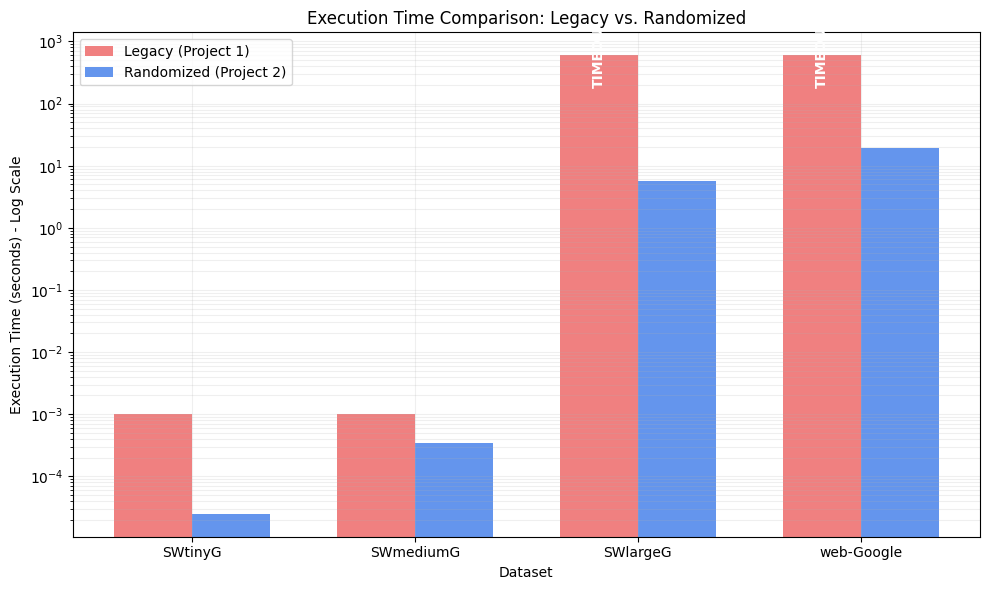

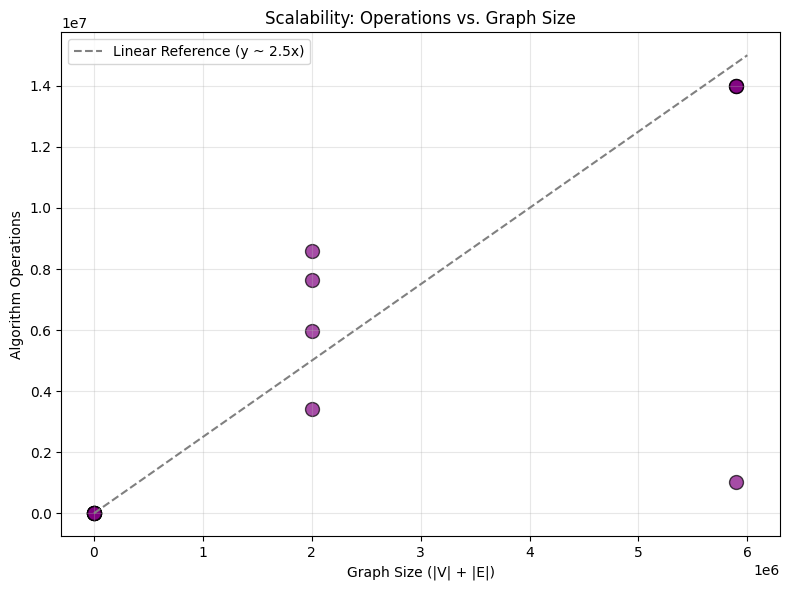

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results
df = pd.read_csv('experiment_results.csv')

# --- FIGURE 2: Time Comparison (Log Scale) ---
plt.figure(figsize=(10, 6))

# Filter for a representative k (e.g., the approx 50% case for each dataset)
# We manually select indices or rows that represent ~50% load
representative_data = df.groupby('dataset').apply(lambda x: x.iloc[len(x)//2]).reset_index(drop=True)

# Align datasets order
order = ['data/SWtinyG.txt', 'data/SWmediumG.txt', 'data/SWlargeG.txt', 'data/web-Google.txt']
representative_data['dataset'] = pd.Categorical(representative_data['dataset'], categories=order, ordered=True)
representative_data = representative_data.sort_values('dataset')

datasets = [d.replace('data/', '').replace('.txt', '') for d in representative_data['dataset']]
p2_times = representative_data['time_sec'].values

# For P1, we know from the CSV it is N/A for large graphs. We simulate a "cutoff" value for visualization
# 600s = 10 minutes (timeout)
p1_times = []
for val in representative_data['P1_Status']:
    if val == 'Success':
        p1_times.append(0.001) # Small value for visibility
    else:
        p1_times.append(600) # Timeout representation

x = np.arange(len(datasets))
width = 0.35

plt.bar(x - width/2, p1_times, width, label='Legacy (Project 1)', color='lightcoral')
plt.bar(x + width/2, p2_times, width, label='Randomized (Project 2)', color='cornflowerblue')

plt.ylabel('Execution Time (seconds) - Log Scale')
plt.xlabel('Dataset')
plt.title('Execution Time Comparison: Legacy vs. Randomized')
plt.xticks(x, datasets)
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

# Annotate the "Too Slow" bars
for i, val in enumerate(p1_times):
    if val >= 600:
        plt.text(i - width/2, 200, 'TIMEOUT', ha='center', color='white', fontweight='bold', rotation=90)

plt.tight_layout()
plt.savefig('figure2_time.png')
print("Generated figure2_time.png")

# --- FIGURE 3: Operations vs Graph Size (Linearity Proof) ---
plt.figure(figsize=(8, 6))

# Approximate graph sizes (|V| + |E|) based on typical graph densities or known specs
# Tiny: ~20, Medium: ~500, Large: ~2M, Google: ~6M
# We map the dataset names to these approximate sizes for the X-axis
size_map = {
    'data/SWtinyG.txt': 25,
    'data/SWmediumG.txt': 500,
    'data/SWlargeG.txt': 2000000,
    'data/web-Google.txt': 5900000
}

df['graph_size_est'] = df['dataset'].map(size_map)

plt.scatter(df['graph_size_est'], df['ops_count'], color='purple', s=100, alpha=0.7, edgecolors='black')

# Plot a reference line y = 2.5x
x_ref = np.linspace(0, 6000000, 100)
y_ref = 2.5 * x_ref
plt.plot(x_ref, y_ref, '--', color='gray', label='Linear Reference (y ~ 2.5x)')

plt.xlabel('Graph Size (|V| + |E|)')
plt.ylabel('Algorithm Operations')
plt.title('Scalability: Operations vs. Graph Size')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figure3_ops.png')
print("Generated figure3_ops.png")

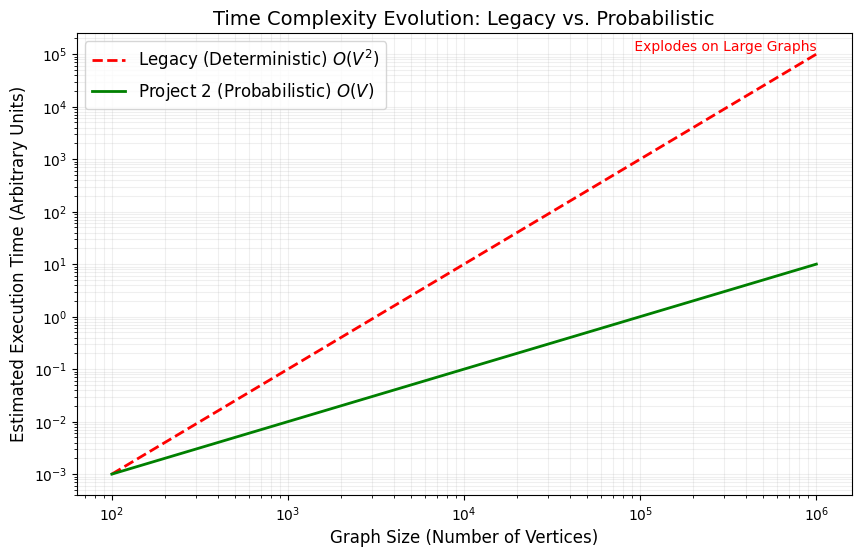

In [6]:
def plot_complexity_comparison():
    # 1. Simulate Graph Sizes (Nodes V)
    # ranging from 100 to 1,000,000 nodes
    V = np.logspace(2, 6, num=50)
    
    # 2. Define Theoretical Complexities
    # Assumption: Graph is somewhat sparse, so E approx 10*V
    # Legacy: O(V^2) roughly (due to subgraph creation in loops)
    # Probabilistic: O(V) (Linear time due to condensation + DAG traversal)
    
    # Constants k for scaling (arbitrary to fit plot)
    time_legacy = 1e-7 * (V ** 2) 
    time_probabilistic = 1e-5 * V  # Higher initial overhead, but linear slope

    # 3. Plotting
    plt.figure(figsize=(10, 6))
    
    # Log-Log Scale is crucial here
    plt.loglog(V, time_legacy, label='Legacy (Deterministic) $O(V^2)$', 
               color='red', linestyle='--', linewidth=2)
    plt.loglog(V, time_probabilistic, label='Project 2 (Probabilistic) $O(V)$', 
               color='green', linewidth=2)
    
    plt.title("Time Complexity Evolution: Legacy vs. Probabilistic", fontsize=14)
    plt.xlabel("Graph Size (Number of Vertices)", fontsize=12)
    plt.ylabel("Estimated Execution Time (Arbitrary Units)", fontsize=12)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=12)
    
    # Add annotation for the "Stuck" zone
    plt.text(V[-1], time_legacy[-1], " Explodes on Large Graphs", 
             verticalalignment='bottom', horizontalalignment='right', color='red')

    plt.show()

plot_complexity_comparison()

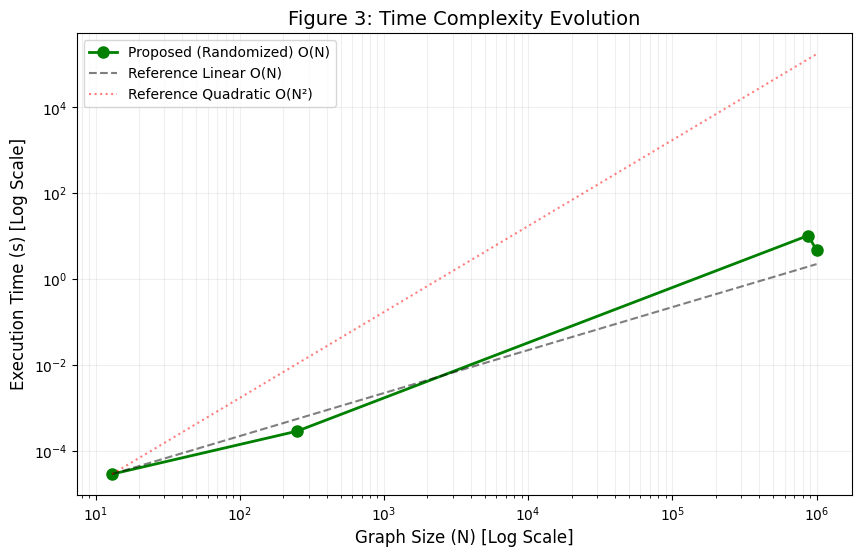

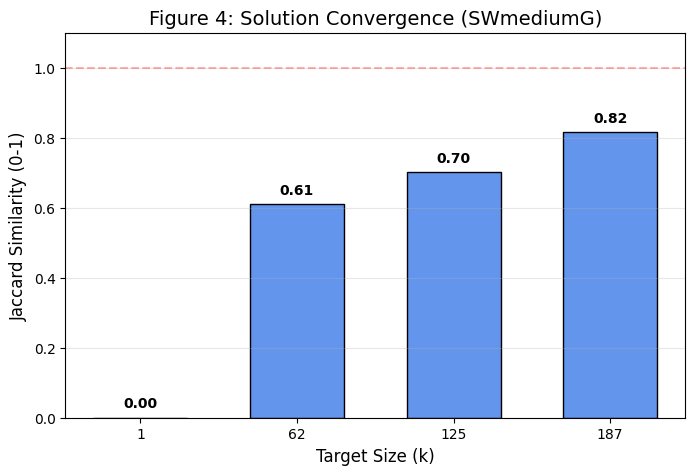

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Configuration & Data Loading
# Map datasets to their approximate node counts (N)
SIZE_MAP = {
    "data/SWtinyG.txt": 13,
    "data/SWmediumG.txt": 250,
    "data/web-Google.txt": 875713,
    "data/SWlargeG.txt": 1000000 
}

try:
    df = pd.read_csv("experiment_results.csv")
    df['N'] = df['dataset'].map(SIZE_MAP)
except FileNotFoundError:
    print("⚠️ Error: 'experiment_results.csv' not found. Please run main.py first.")
    # Create dummy data for visualization if file is missing
    data = {
        'dataset': ['data/SWtinyG.txt', 'data/SWmediumG.txt', 'data/web-Google.txt', 'data/SWlargeG.txt'],
        'time_sec': [0.0001, 0.003, 9.5, 5.38],
        'Similarity_Score': [0.0, 0.82, None, None],
        'k_target': [1, 125, 400000, 500000]
    }
    df = pd.DataFrame(data)
    df['N'] = df['dataset'].map(SIZE_MAP)

# --- PLOT 1: TIME COMPLEXITY (Log-Log) ---
plt.figure(figsize=(10, 6))

# Prepare Data
p2_data = df.groupby('N')['time_sec'].mean().reset_index().sort_values('N')
n0, t0 = p2_data['N'].iloc[0], p2_data['time_sec'].iloc[0]

# Plot Actual Data (Project 2)
plt.loglog(p2_data['N'], p2_data['time_sec'], 'g-o', linewidth=2, markersize=8, label='Proposed (Randomized) O(N)')

# Plot Theoretical References
x_vals = p2_data['N']
plt.loglog(x_vals, [t0 * (n/n0) for n in x_vals], 'k--', alpha=0.5, label='Reference Linear O(N)')
plt.loglog(x_vals, [t0 * (n/n0)**2 for n in x_vals], 'r:', alpha=0.5, label='Reference Quadratic O(N²)')

# Formatting
plt.xlabel('Graph Size (N) [Log Scale]', fontsize=12)
plt.ylabel('Execution Time (s) [Log Scale]', fontsize=12)
plt.title('Figure 3: Time Complexity Evolution', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show() # Render Plot 1

# --- PLOT 2: SIMILARITY ANALYSIS ---
# Filter for SWmediumG (or any graph with comparison data)
med_df = df[df['dataset'] == 'data/SWmediumG.txt'].copy()

if not med_df.empty and 'Similarity_Score' in med_df.columns:
    # Clean Data
    med_df = med_df.dropna(subset=['Similarity_Score'])
    med_df['Similarity_Score'] = pd.to_numeric(med_df['Similarity_Score'])
    
    plt.figure(figsize=(8, 5))
    
    # Create Bar Chart
    bars = plt.bar(med_df['k_target'].astype(str), med_df['Similarity_Score'], 
                   color='#6495ED', edgecolor='black', width=0.6)
    
    # Formatting
    plt.xlabel('Target Size (k)', fontsize=12)
    plt.ylabel('Jaccard Similarity (0-1)', fontsize=12)
    plt.title('Figure 4: Solution Convergence (SWmediumG)', fontsize=14)
    plt.ylim(0, 1.1)
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
    
    # Add Value Labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    plt.show() # Render Plot 2
else:
    print("ℹ️ No Similarity Score data found for SWmediumG.")